# Реализация случайного леса

#### Случайны лес был выбран из-за его устойчивости к шуму, возможности самостоятельной обработки выбросов в данных, высокой точности из-за объединения прогнозов нескольких деревьев.

In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [272]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,2.051143
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.971137
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,1.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,2.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,2.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,5.000000


---
## Работа с данными

In [224]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

#### Поскольку цель - создать модель регрессии, то нужно конвертировать значения столбца ocean_proximity в числа  

#### Для начала посмотрим, какие значения принимает столбец ocean_proximity

In [277]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

# Добавим "вес" для каждого значения вручную

In [280]:
weight_for_df = {'NEAR BAY': 3, '<1H OCEAN':2, 'INLAND':1, 'NEAR OCEAN':4, 'ISLAND':5}

# Заменим старый ocean_proximity на новый, с числами

In [283]:
df['ocean_proximity'] = df['ocean_proximity'].map(weight_for_df)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


In [340]:
clmns = df.columns.tolist()
target, ocean = clmns.index('median_house_value'), clmns.index('ocean_proximity')
clmns[target], clmns[ocean] = clmns[ocean], clmns[target]
df = df[clmns]
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3,342200.0
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,1,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,1,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,1,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,1,84700.0


# Теперь все данные в датафрейме - числа

In [343]:
# посмотрим, есть ли пропуски в данных (их наличие помешает обучить модель регрессии) 
df.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
ocean_proximity       False
median_house_value    False
dtype: bool

# Пропуски есть в total_bedrooms - посмотрим сколько их

In [346]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

#### На 20640 строк датасета имеется лишь 207 значений с NaN - это около 1 % от всего датасета. Так что лучше просто их удалить, дабы не вносить  выдумки в данные.

In [349]:
df = df.dropna(subset=['total_bedrooms'])
df.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
ocean_proximity       False
median_house_value    False
dtype: bool

# Найдем возможные выбросы с помощью ящика с усами

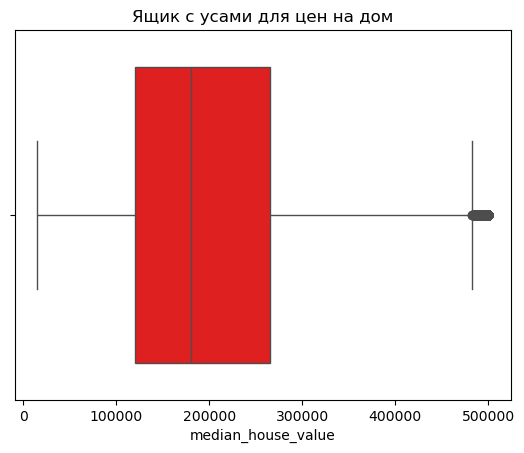

In [351]:
import seaborn as sns

sns.boxplot(x=df['median_house_value'], color='red')
plt.title('Ящик с усами для цен на дом')
plt.show()

#### Не видим явных выбросов на ящике с усами - переходим к разбиению данных на обучающую и тестовую выборку!

```
вообще, правильнее было бы использовать межквартильный размах, чтобы исключить потенциально "странные" данные, но поскольку мы не видим никаких
выбросов на ящике с усами, не делаем этого
```

### Но перед тем как создавать и обучать модель подберем для нее гиперпараметры.

In [353]:
from sklearn.model_selection import RandomizedSearchCV

rand_forest_model_for_params = RandomForestRegressor(random_state=12)

# значения параметров, из которых будем выбирать
params = {
    'n_estimators': [ 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rand_forest_model_for_params = RandomizedSearchCV(rand_forest_model_for_params, param_distributions=params, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rand_forest_model_for_params.fit(X_train, y_train)
gipermarams.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None}

### Cоздание и обучение модели c гиперпареметрами выше

In [355]:
# создание
rand_forest_model = RandomForestRegressor(
    n_estimators=400, # колво деревьев 
    max_depth=None, # макс глубина дерева (колво разбиений, None - без ограничений)
    min_samples_split=2, # минимальное колво образов для разделения узлов (для избежания переобучения)
    min_samples_leaf=2, # минимум образов в листе 
    max_features="sqrt", 
    random_state=14
)

In [357]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=18)

In [359]:
# обучение
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=400,
                      random_state=14)

In [361]:
# предсказание модели
y_pred = rand_forest_model.predict(X_test)
pd.DataFrame({"Предсказание модели": y_pred, "Реальное значение": y_test}).head()

,Предсказание модели,Реальное значение
17966,299847.612044,288900.0
5410,415394.911448,386000.0
19414,175789.419048,155900.0
15525,126341.000893,136300.0
12830,98715.371627,96200.0


In [385]:
# метрики
print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")
print(f"R2 = {r2_score(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")

RMSE = 47623.36039745107
R2 = 0.8256272451573637
MAE = 32017.681344166005
